# Multi-Agent Workflows + RAG - LangGraph

Today we'll be looking at an example of a Multi-Agent workflow that's powered by LangGraph, LCEL, and more!

We're going to be, more specifically, looking at a "heirarchical agent teams" from the [AutoGen: Enabling Next-Gen LLM
Applications via Multi-Agent Conversation](https://arxiv.org/pdf/2308.08155) paper.

This will be the final "graph" of our system:

![image](https://i.imgur.com/Bhc7RVE.png)

It's important to keep in mind that the actual implementation will be constructed of 3 separate graphs, the final one having 2 graphs as nodes! LangGraph is a heckuva tool!

> NOTE: We'll be following along with the official LangGraph implementation very closely, which you can find [here](https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/hierarchical_agent_teams.ipynb), with some minor modifications and extensions to showcase just how straightforward it is to modify LangGraph implementations to suit your own needs!



## Dependencies

We'll start, as we normally do, by grabbing our dependencies.

In [1]:
!poetry install

Installing dependencies from lock file

No dependencies to install or update


Since we'll be relying on OpenAI's suite of models to power our agents today, we'll want to provide our OpenAI API Key.

We're also going to be using the Tavily search tool - so we'll want to provide that API key as well!

Instruction for how to obtain the Tavily API key can be found:

1. [Tavily API Key](https://app.tavily.com/sign-in)



In [2]:
import os
from getpass import getpass
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"LangGraph - Multi-Agent"
if "LANGCHAIN_API_KEY" not in os.environ:
    os.environ["LANGCHAIN_API_KEY"] = getpass('Enter your LangSmith API key: ')
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("OpenAI API Key: ")
if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass("Tavily API Key: ")    

## Simple LCEL RAG

Now that we have our dependencies set-up - let's create a simple RAG chain that works over a single PDF.

> NOTE: While this particular example is very straight forward - you can "plug in" any complexity of chain you desire as a node in a LangGraph.

## Retrieval

The 'R' in 'RAG' - this is, at this point, fairly straightforward!

#### Data Collection and Processing

A classic first step, at this point, let's grab our desired document!

In [3]:
from typing import List
from langchain.document_loaders import PyMuPDFLoader
from langchain_core.documents.base import Document
url:str = "https://arxiv.org/pdf/2404.19553"
docs: List[Document] = PyMuPDFLoader(url).load()

Now we can chunk it down to size!

In [4]:
from typing import List
import tiktoken

def tiktoken_len(text) -> int:
    tokens: List[int] = tiktoken.encoding_for_model("gpt-4o-mini").encode(
        text,
    )
    return len(tokens)

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

chunk_size : int = 300
chunk_overlap : int = 0
text_splitter: RecursiveCharacterTextSplitter = RecursiveCharacterTextSplitter(
    chunk_size = chunk_size,
    chunk_overlap = chunk_overlap,
    length_function = tiktoken_len,
)

In [6]:
from typing import List


from langchain_core.documents.base import Document


split_chunks: List[Document] = text_splitter.split_documents(docs)


Now we've successfully split our single PDF into...

In [7]:
len(split_chunks)

15

documents!

#### Embedding Model and Vector Store

Now that we have our chunked document - lets create a vector store, which will first require us to create an embedding model to get the vector representations of our text!

We'll use OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) model - as it's cheap, and performant.

In [8]:
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.embeddings import Embeddings
# NOTE: use Embedding abstract class to make it more generic in case 
# we want to change embedding model in the future 
embedding_model : Embeddings= OpenAIEmbeddings(model="text-embedding-3-small")

Now we can create our QDrant backed vector store!

In [9]:
from qdrant_client import QdrantClient
from qdrant_client.http import models as rest
from langchain_community.vectorstores import Qdrant

def create_qdrant_collection_if_not_exists(client: QdrantClient, collection_name: str, vector_size: int) -> bool:
    """
    This function does the following:

    1. It attempts to get the collection information using `client.get_collection()`.
    2. If successful, it means the collection already exists, so it prints a message and returns `False`.
    3. If a `ValueError` is raised, it means the collection doesn't exist. In this case, it creates the collection and returns `True`.

    You can use this function before creating your Qdrant vector store. If the collection already exists, you can choose to use the existing collection or update it as needed. If it doesn't exist, you can proceed with creating a new collection and adding your documents.

    This approach is based on the Qdrant documentation for checking collection existence and creating collections [1][2].

    [1] https://qdrant.tech/documentation/concepts/collections/
    [2] https://github.com/qdrant/qdrant/issues/3332
    """
    try:
        # Check if the collection exists
        collection_info: rest.CollectionInfo = client.get_collection(collection_name)
        print(f"Collection '{collection_name}' already exists.")
        return False
    except ValueError:
        # Collection doesn't exist, so create it
        client.create_collection(
            collection_name=collection_name,
            vectors_config=rest.VectorParams(size=vector_size, distance=rest.Distance.COSINE)
        )
        print(f"Collection '{collection_name}' created successfully.")
        return True

# Usage example:
qdrant_collection_name = "extending_context_window_llama_3"
vector_size: int = len(embedding_model.embed_query("Sample text"))  # Get the vector size from your embedding model
client = QdrantClient(":memory:")  # Use the appropriate client configuration
created: bool = create_qdrant_collection_if_not_exists(client, qdrant_collection_name, vector_size)

if not created:
    # Collection already existed, you might want to update it or use it as is
    qdrant_vectorstore = Qdrant(
        client=client,
        collection_name=qdrant_collection_name,
        embedding_function=embedding_model.embed_query
    )
else:
    # New collection was created, proceed with adding documents
    qdrant_vectorstore: Qdrant = Qdrant.from_documents(
        split_chunks,
        embedding_model,
        location=":memory:",
        collection_name=qdrant_collection_name,
    )


# from langchain_community.vectorstores import Qdrant
# qdrant_collection_name:str="extending_context_window_llama_3" 
# qdrant_vectorstore: Qdrant = Qdrant.from_documents(
#     split_chunks,
#     embedding_model,
#     location=":memory:",
#     collection_name=qdrant_collection_name,
# )


Collection 'extending_context_window_llama_3' created successfully.


Let's make sure we can access it as a retriever.

In [10]:
from langchain_core.vectorstores.base import VectorStoreRetriever


qdrant_retriever: VectorStoreRetriever = qdrant_vectorstore.as_retriever()

### Augmented

Now that we have our retrieval process set-up, we need to set up our "augmentation" process - AKA a prompt template.

In [11]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """
CONTEXT:
{context}

QUERY:
{question}

You are a helpful assistant. Use the available context to answer the question. If you can't answer the question, say you don't know.
"""

rag_prompt: ChatPromptTemplate = ChatPromptTemplate.from_template(RAG_PROMPT)

### Generation

Last, but certainly not least, let's put the 'G' in 'RAG' by adding our generator - in this case, we can rely on OpenAI's [`gpt-4o-mini`](https://platform.openai.com/docs/models/gpt-4o-mini) model!

In [12]:
from langchain_openai import ChatOpenAI
from langchain_core.language_models.chat_models import BaseChatModel
# openai_chat_model = ChatOpenAI(model="gpt-4o-mini")
openai_chat_model : BaseChatModel = ChatOpenAI(model="gpt-4-turbo")

### RAG - Retrieval Augmented Generation

All that's left to do is combine our R, A, and G into a single chain - and we're off!

In [13]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser
from langchain_core.runnables import Runnable, RunnableSerializable
from typing import Any,Dict
# rag_chain:RunnableSerializable[Any,str] = (
rag_chain:RunnableSerializable[Dict[str, str], str] = (
    {"context": itemgetter("question") | qdrant_retriever, "question": itemgetter("question")}
    | rag_prompt | openai_chat_model | StrOutputParser()
)

Let's test this out and make sure it works.

In [14]:
rag_chain.invoke({"question" : "What does the 'context' in 'long context' refer to?"})

"In the provided documents, the term 'context' in 'long context' refers to the amount of textual information or content that a language model can consider at one time when processing or generating text. This is particularly relevant in tasks like question-answering or summarization, where understanding or referencing a larger portion of text can lead to more accurate or relevant outputs. The discussions in the documents involve extending this context length to enhance the capabilities of language models like Llama-3-8B-Instruct to handle longer texts effectively, which is critical for operations on extensive documents like books or detailed technical reports."

Here's the dataflow diagram:

```plaintext
┌─────────────────┐    ┌─────────────────┐    ┌─────────────────┐    ┌─────────────────┐    ┌─────────────────┐
│                 │    │                 │    │                 │    │                 │    │                 │
│    📥 Input     │ -> │ 🔍 Retriever    │ -> │ 📝 RAG Prompt   │ -> │ 🧠 LLM          │ -> │ 🔤 Output       │
│    Question     │    │ (Qdrant)        │    │                 │    │ (OpenAI)        │    │ Parser          │
│                 │    │                 │    │                 │    │                 │    │                 │
└─────────────────┘    └─────────────────┘    └─────────────────┘    └─────────────────┘    └─────────────────┘
```

Now, let's go through an example input and see how it's processed step by step:

Input: 
```python
{"question": "What does the 'context' in 'long context' refer to?"}
```

Step 1: 📥 Input Question
- The input dictionary is received by the `rag_chain`.

Step 2: 🔍 Retriever (Qdrant)
- The question is passed to the Qdrant retriever.
- The retriever searches for relevant documents in the vector store.
- Let's say it retrieves a chunk of text: "In the context of 'long context', 'context' refers to the amount of text or information that a language model can process at one time. It pertains to the model's ability to handle larger amounts of input data for tasks like question-answering and summarization."

Step 3: 📝 RAG Prompt
- The retrieved context and the original question are inserted into the RAG prompt template:
```
CONTEXT:
In the context of 'long context', 'context' refers to the amount of text or information that a language model can process at one time. It pertains to the model's ability to handle larger amounts of input data for tasks like question-answering and summarization.

QUERY:
What does the 'context' in 'long context' refer to?

You are a helpful assistant. Use the available context to answer the question. If you can't answer the question, say you don't know.
```

Step 4: 🧠 LLM (OpenAI)
- The formatted prompt is sent to the OpenAI chat model (gpt-4o-mini).
- The model generates a response based on the prompt.

Step 5: 🔤 Output Parser
- The LLM's response is passed through the StrOutputParser.
- This ensures the output is a clean string without any additional formatting.

Final Output:
```
"In the context of 'long context', 'context' refers to the amount of text or information that a language model can process at one time. Specifically, it pertains to the model's ability to handle larger amounts of input data for tasks like question-answering and summarization. The term 'long context' implies an extended capacity for processing more text or information in a single instance compared to models with shorter context lengths."
```

This example demonstrates how the `rag_chain` processes the input question, retrieves relevant information, formats it into a prompt, generates a response using an LLM, and then parses the output to provide a final answer.


### RAG Limitation

Notice how we're hard-coding our data, while this is simply meant to be an illustrative example - you could easily extend this to work with any provied paper or document in order to have a more dynamic system.

For now, we'll stick with this single hard-coded example in order to keep complexity down in an already very long notebook!

##### 🏗️ Activity #1 (Bonus Marks)

Allow the system to dynamically fetch Arxiv papers instead of hard coding them.

In [15]:
import arxiv
from arxiv import Client, Search, Result
from typing import List
from langchain_core.documents.base import Document
import requests
import pypdfium2 as pdfium
from typing import Dict, Generator, List, Optional

def fetch_arxiv_paper(query: str, max_results: int = 1) -> List[Document]:
    client: Client = arxiv.Client()
    search: Search = arxiv.Search(
        query=query,
        max_results=max_results,
        sort_by=arxiv.SortCriterion.Relevance
    )
    docs: List[Document] = []
    for result in client.results(search):
        result: Result
        # Download the PDF content
        pdf_url: str = result.pdf_url
        response: requests.Response = requests.get(pdf_url)
        pdf_content: bytes = response.content
        
        # Use PyPDFium2 to load the PDF content
        pdf: pdfium.PdfDocument = pdfium.PdfDocument(pdf_content)
        
        for page_number in range(len(pdf)):
            page: pdfium.PdfPage = pdf[page_number]
            text_page: pdfium.PdfTextPage = page.get_textpage()
            text_content: str = text_page.get_text_bounded()
            docs.append(Document(
                page_content=text_content, 
                metadata={"source": pdf_url, "page": page_number + 1}
            ))
        
    return docs

query: str = "Extending context window for large language models"
docs: List[Document] = fetch_arxiv_paper(query)

In [16]:
len(docs)
docs[0]

Document(metadata={'source': 'http://arxiv.org/pdf/2405.18009v1', 'page': 1}, page_content='Exploring Context Window of Large Language Models\r\nvia Decomposed Positional Vectors\r\nZican Dong1∗, Junyi Li1,3∗, Xin Men4, Wayne Xin Zhao1†, Bingning Wang4\r\nZhen Tian1, Weipeng Chen4, Ji-Rong Wen1,2\r\n1 Gaoling School of Artificial Intelligence, Renmin University of China\r\n2 School of Information, Renmin University of China\r\n3 DIRO, Université de Montréal\r\n4 Baichuan Inc.\r\n{dongzican,lijunyi}@ruc.edu.cn\r\nbatmanfly@gmail.com, daniel@baichuan-inc.com\r\nAbstract\r\nTransformer-based large language models (LLMs) typically have a limited context\r\nwindow, resulting in significant performance degradation when processing text\r\nbeyond the length of the context window. Extensive studies have been proposed to\r\nextend the context window and achieve length extrapolation of LLMs, but there is\r\nstill a lack of in-depth interpretation of these approaches. In this study, we explore\r\n

## Helper Functions for Agent Graphs

We'll be using a number of agents, nodes, and supervisors in the rest of the notebook - and so it will help to have a collection of useful helper functions that we can leverage to make our lives easier going forward.

Let's start with the most simple one!

#### Import Wall

Here's a wall of imports we'll be needing going forward!

In [17]:
# NOTE: commented out as I prefer importing in the cells that they 
# are being used

# from typing import Any, Callable, List, Optional, TypedDict, Union
# from langchain.agents import AgentExecutor, create_openai_functions_agent
# from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
# from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
# from langchain_core.runnables import Runnable
# from langchain_core.tools import BaseTool
# from langchain_openai import ChatOpenAI

# from langgraph.graph import END, StateGraph

### Agent Node Helper

Since we're going to be wrapping each of our agents into a node - it will help to have an easy way to create the node!

In [18]:
from typing import Dict, List, Any
from langchain_core.messages import HumanMessage
from langchain.agents import AgentExecutor

def agent_node(
    state: Dict[str, Any],
    agent: AgentExecutor,
    name: str
) -> Dict[str, List[HumanMessage]]:
    result: Dict[str, str] = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Agent Creation Helper Function

Since we know we'll need to create agents to populate our agent nodes, let's use a helper function for that as well!

Notice a few things:

1. We have a standard suffix to append to our system messages for each agent to handle the tool calling and boilerplate prompting.
2. Each agent has its our scratchpad.
3. We're relying on OpenAI's function-calling API for tool selection
4. Each agent is its own executor.

In [19]:
from typing import List
from langchain_core.prompts.chat import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain_core.tools import BaseTool
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.runnables import Runnable
from langchain_core.language_models.chat_models import BaseChatModel
def create_agent(
    llm: BaseChatModel,
    tools: List[BaseTool],
    system_prompt: str,
) -> AgentExecutor:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason! You are one of the following team members: {team_members}.")
    prompt: ChatPromptTemplate = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent: Runnable = create_openai_functions_agent(llm, tools, prompt)
    executor: AgentExecutor = AgentExecutor(agent=agent, tools=tools)
    return executor

### Supervisor Helper Function

Finally, we need a "supervisor" that decides and routes tasks to specific agents.

Since each "team" will have a collection of potential agents - this "supervisor" will act as an "intelligent" router to make sure that the right agent is selected for the right task.

Notice that, at the end of the day, this "supervisor" is simply directing who acts next - or if the state is considered "done".

In [20]:
from typing import List, Dict, Any
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.runnables import RunnableSerializable

def create_team_supervisor(
    llm: ChatOpenAI,
    system_prompt: str,
    members: List[str]
) -> RunnableSerializable[Dict[str, Any], Dict[str, str]]:
    options: List[str] = ["FINISH"] + members
    function_def: Dict[str, Any] = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    
    prompt: ChatPromptTemplate = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    
    return (
        prompt
        # NOTE: bind_functions only exists for openai models and is not part of BaseChatModel
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

## Research Team - A LangGraph for Researching A Specific Topic

Now that we have our RAG chain set-up and some awesome helper functions, we want to create a LangGraph related to researching a specific topic.

We're going to start by equipping our Research Team with a few tools:

1. Tavily Search - aka "Google", for the most up to date information possible.
2. Our RAG chain - specific and high quality information about our topic.

Let's create those tools now!

### Tool Creation

As you can see below, some tools already come pre-packaged ready to use!

In [21]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

There is a bug  with `TavilySearchResults` as of `langchain-community` version
`0.2.15`. In case your API key is not correct, it just shows a message like the
following when you call `invoke()` on it:

```json
{
  "content": "HTTPError(401 Client Error: Unauthorized for url: https://api.tavily.com/search)",
  "additional_kwargs": {},
  "response_metadata": {},
  "type": "tool",
  "name": "tavily_search_results_json",
  "id": null,
  "tool_call_id": "foo",
  "artifact": {},
  "status": "success"
}

```

As you can notice, it thinks `"status": "success"` so it won't raise an
exception.


The following section runs a basic check to ensure there are no errors while
taking this bug into account.

In [22]:
from langchain_community.tools.tavily_search import TavilySearchResults
import requests
from langchain_core.messages import ToolMessage
import json

def test_tavily_tool() -> bool:
    tool = TavilySearchResults(
        max_results=3,
        include_answer=True,
        include_raw_content=True,
    )
    
    try:
        result: ToolMessage = tool.invoke({"args": {'query': 'who won the last french open'}, "type": "tool_call", "id": "foo", "name": "tavily"})
        
        # Parse the JSON content of the ToolMessage
        result_dict = json.loads(result.json())
        
        # Check if the content field contains an error message
        if 'HTTPError' in result_dict['content']:
            print(f"Error detected in content: {result_dict['content']}")
            return False
        
        print("Tavily search successful:")
        print(result.json())
        return True
    
    except requests.exceptions.RequestException as e:
        print(f"Request exception occurred: {e}")
        return False
    except json.JSONDecodeError as e:
        print(f"JSON decode error: {e}")
        return False
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return False

# Run the test
if test_tavily_tool():
    print("Tavily tool is working correctly!")
else:
    print("There was an issue with the Tavily tool. Please check your API key and internet connection.")

Tavily search successful:
{"content": "[{\"url\": \"https://www.topendsports.com/events/tennis-grand-slam/french-open/winners-men.htm\", \"content\": \"Here are all the winners of the French Tennis Open men's title since the first tournament in 1925. The recent tournaments have been dominated by Spanish player Rafael Nadal. ... He now has 14 French Open men's singles titles (the last in 2022). See also the Women's Singles Results. Year Winner 2nd Score; 2024: Carlos Alcaraz (Spain) Alexander ...\"}, {\"url\": \"https://apnews.com/article/djokovic-ruud-french-open-roland-garros-final-d7bda9f570b010ea48cf8a05b397291e\", \"content\": \"Novak Djokovic wins his 23rd Grand Slam title by beating Casper Ruud in the French Open final\\nSerbia\\u2019s Novak Djokovic celebrates winning the men\\u2019s singles final match of the French Open tennis tournament against Norway\\u2019s Casper Ruud in three sets, 7-6, (7-1), 6-3, 7-5, at the Roland Garros stadium in Paris, Sunday, June 11, 2023. Serbia\

Creating a custom tool, however, is very straightforward.

> NOTE: You *must* include a docstring, as that is what the LLM will consider when deciding when to use this tool.

In [23]:
# from typing import Annotated, List, Tuple, Union
# from langchain_core.tools import tool

# @tool
# def retrieve_information(
#     query: Annotated[str, "query to ask the retrieve information tool"]
#     ) -> str:
#   """Use Retrieval Augmented Generation to retrieve information about the 'Extending Llama-3’s Context Ten-Fold Overnight' paper."""
#   return rag_chain.invoke(input={"question" : query})

In [24]:
from langchain.tools import BaseTool
from langchain.pydantic_v1 import BaseModel, Field
from typing import Optional, Type

class RetrieveInformationInput(BaseModel):
    query: str = Field(..., description="Query to ask the retrieve information tool")

class RetrieveInformationTool(BaseTool):
    name: str = "retrieve_information"
    description: str = "Use Retrieval Augmented Generation to retrieve information about the 'Extending Llama-3's Context Ten-Fold Overnight' paper."
    args_schema: Optional[Type[BaseModel]] = RetrieveInformationInput

    def _run(self, query: str) -> str:
        return rag_chain.invoke(input={"question": query})

    def _arun(self, query: str) -> str:
        # If you need async support, implement this method
        # For now, we'll just call the sync version
        return self._run(query)

retrieve_information = RetrieveInformationTool()

> NOTE: We could just as easily use the LCEL chain directly, since nodes can be LCEL objects - but creating a tool helps explain the tool creation process at the same time.

### Research Team State

Since we're using LangGraph - we're going to need state!

Let's look at how we've created our state below.

In [25]:
import functools
import operator
from langgraph.graph import StateGraph

from langchain_core.messages import BaseMessage, HumanMessage
from typing import Annotated, List,TypedDict

class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

Notice how we've used `messages`, `team_members`, and `next`.

These states will help us understand:

1. What we've done so far (`messages`)
2. Which team members we have access to (`team_members`)
3. Which team member is up next! (`next`)

### Research Team LLM

We'll be using `gpt-4-turbo` today. This LLM is going to be doing a lot of reasoning - and so using a "powerful" LLM is very important here!

In [26]:
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.language_models.chat_models import BaseChatModel
llm : ChatOpenAI = ChatOpenAI(model="gpt-4-turbo")

##### ❓ Question #1:

Why is a "powerful" LLM important for this use-case?

What tasks must our Agent perform that make it such that the LLM's reasoning capability is a potential limiter?

#### 🔍Answer #1:

the following are tasks that require significant reasoning capability:

1. Complex Task Coordination:
The LLM needs to coordinate between multiple agents (Search, PaperInformationRetriever, and Supervisor) and understand their roles and capabilities. This requires a high level of reasoning to decide which agent should act next based on the current state and goal.

2. Information Synthesis:
The LLM must synthesize information from multiple sources (search results and paper-specific information) to form coherent and relevant responses. This involves understanding context, relevance, and how different pieces of information relate to each other.

3. Task Decomposition:
Breaking down complex research queries into subtasks that can be handled by different agents requires sophisticated reasoning. The LLM needs to understand the overall goal and how to efficiently divide the work.

4. Natural Language Understanding:
The LLM must interpret user queries, which can be complex and nuanced, especially when dealing with technical topics like AI research papers.

5. Contextual Decision Making:
Deciding when to switch between agents or when to conclude the research process (FINISH) requires understanding the current state of knowledge and the quality of information gathered so far.

6. Handling Ambiguity:
Research questions often involve ambiguity. A powerful LLM is needed to navigate unclear aspects of queries and decide how to proceed when information is incomplete or contradictory.

7. Specialized Knowledge Application:
Understanding and working with technical AI concepts mentioned in the paper requires a model with broad and deep knowledge in the field.

8. Output Quality and Coherence:
Generating high-quality, coherent responses that accurately reflect the research findings and meet the user's needs requires advanced language generation capabilities.

9. Error Handling and Recovery:
The ability to recognize when an approach isn't working and to adjust the strategy accordingly requires sophisticated reasoning.

10. Instruction Following with Flexibility:
The LLM needs to follow the given instructions (like using specific tools) while also being flexible enough to handle unexpected scenarios or information.

These tasks require a high degree of reasoning, context understanding, and knowledge application, which are characteristics of more powerful LLMs. A less capable model might struggle with these complex cognitive tasks, potentially leading to less accurate research outcomes, poor task allocation, or inability to effectively synthesize information from multiple sources.

### Research Team Agents & Nodes

Now we can use our helper functions to create our agent nodes, with their related tools.

Let's start with our search agent node.

#### Research Team: Search Agent

We're going to give our agent access to the Tavily tool, power it with our GPT-4 Turbo model, and then create its node - and name it `Search`.

In [27]:
import functools;
from langchain.agents.agent import AgentExecutor
from typing import Callable, List, Dict, Any
from langchain_core.messages import  HumanMessage

search_agent: AgentExecutor = create_agent(
    llm,
    [tavily_tool],
    "You are a research assistant who can search for up-to-date info using the tavily search engine.",
)
# search_node  = functools.partial(agent_node, agent=search_agent, name="Search")
search_node: Callable[[Dict[str, Any]], Dict[str, List[HumanMessage]]] = functools.partial(agent_node, agent=search_agent, name="Search")

#### Research Team: RAG Agent Node

Now we can wrap our LCEL RAG pipeline in an agent node as well, using the LCEL RAG pipeline as the tool, as created above.

In [28]:
from langchain.agents.agent import AgentExecutor

import functools;

research_agent: AgentExecutor = create_agent(
    llm,
    [retrieve_information],
    "You are a research assistant who can provide specific information on the provided paper: 'Extending Llama-3’s Context Ten-Fold Overnight'. You must only respond with information about the paper related to the request.",
)
research_node: Callable[[Dict[str, Any]], Dict[str, List[HumanMessage]]] = functools.partial(agent_node, agent=research_agent, name="PaperInformationRetriever")

### Research Team Supervisor Agent

Notice that we're not yet creating our supervisor *node*, simply the agent here.

Also notice how we need to provide a few extra pieces of information - including which tools we're using.

> NOTE: It's important to use the *exact* tool name, as that is how the LLM will reference the tool. Also, it's important that your tool name is all a single alphanumeric string!



In [29]:
from typing import Any, Dict


from langchain_core.runnables.base import RunnableSerializable


supervisor_agent: RunnableSerializable[Dict[str, Any], Dict[str, str]] = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, PaperInformationRetriever. Given the following user request,"
    " determine the subject to be researched and respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. "
    " You should never ask your team to do anything beyond research. They are not required to write content or posts."
    " You should only pass tasks to workers that are specifically research focused."
    " When finished, respond with FINISH."),
    ["Search", "PaperInformationRetriever"],
)

### Research Team Graph Creation

Now that we have our research team agent nodes created, and our supervisor agent - let's finally construct our graph!

We'll start by creating our base graph from our state, and then adding the nodes/agent we've created as nodes on our LangGraph.

In [30]:
from langgraph.graph import StateGraph
research_graph:StateGraph = StateGraph(ResearchTeamState)

research_graph.add_node("Search", search_node)
research_graph.add_node("PaperInformationRetriever", research_node)
research_graph.add_node("supervisor", supervisor_agent)

Now we can define our edges - include our conditional edge from our supervisor to our agent nodes.

Notice how we're always routing our agent nodes back to our supervisor!

In [31]:
from langgraph.graph import END

research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("PaperInformationRetriever", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "PaperInformationRetriever": "PaperInformationRetriever", "FINISH": END},
)

Now we can set our supervisor node as the entry point, and compile our graph!

In [32]:
research_graph.set_entry_point("supervisor")
from langgraph.graph.graph import CompiledGraph
chain:CompiledGraph = research_graph.compile()

#### Display Graph

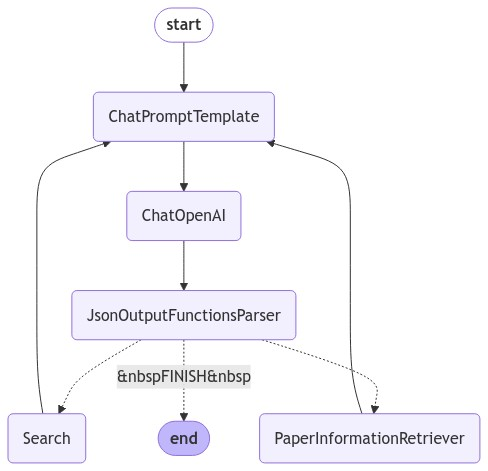

In [33]:
from IPython.display import Image, display

try:
    display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
except:
    pass



The next part is key - since we need to "wrap" our LangGraph in order for it to be compatible in the following steps - let's create an LCEL chain out of it!

This allows us to "broadcast" messages down to our Research Team LangGraph!

In [34]:
from typing import Dict, List, Any
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableSerializable

def enter_chain(input_dict: Dict[str, str], team_members: List[str]) -> Dict[str, Any]:
    results: Dict[str, Any] = {
        "messages": [HumanMessage(content=input_dict["question"])],
        "team_members": ", ".join(team_members),
    }
    return results

research_chain: RunnableSerializable[Dict[str, str], Dict[str, List[HumanMessage]]] = (
    functools.partial(enter_chain, team_members=["Search", "PaperInformationRetriever"])
    | chain
)



Now, finally, we can take it for a spin!

In [35]:
# for s in research_chain.stream(
#     {"question": "What are the main takeaways from the paper `Extending Llama-3's Context Ten-Fold Overnight'? Please use Search and PaperInformationRetriever!"},
#     {"recursion_limit": 100}
# ):
#     if "__end__" not in s:
#         print(s)
#         print("---")

In [36]:
from langchain_core.messages import HumanMessage
from langgraph.pregel.io import AddableUpdatesDict
import json
for s in research_chain.stream(
    {"question": "What are the main takeaways from the paper `Extending Llama-3's Context Ten-Fold Overnight'? Please use Search and PaperInformationRetriever!"},
    {"recursion_limit": 100}
):
    if not isinstance(s, AddableUpdatesDict):
       print("not an AddableUpdatesDict. type: ", type(s).__name__)
       continue
    # iterate over keys and pretty print the values
    print(json.dumps(
        s,
        indent=4,
        default=lambda x: x.__dict__,
        ensure_ascii=False
    ))
    print("---")

{
    "supervisor": {
        "next": "Search"
    }
}
---
{
    "Search": {
        "messages": [
            {
                "content": "The main takeaways from the paper \"Extending Llama-3's Context Ten-Fold Overnight\" are:\n\n1. **Extension of Context Length**: The researchers successfully extended the context length of the Llama-3-8B-Instruct model from 8,000 tokens to 80,000 tokens. This was achieved using a method called QLoRA fine-tuning.\n\n2. **Efficiency of Training**: The training process was highly efficient, taking only 8 hours on a single machine equipped with 8xA800 (80G) GPUs.\n\n3. **Use of Synthetic Training Data**: The dramatic increase in context length was facilitated by the use of 3,500 synthetic training samples, which were generated by a more powerful language model, GPT-4.\n\n4. **Improved Model Performance**: The resulting model demonstrated superior performance across a broad range of evaluation tasks, indicating that the extended context length signific

##### 🏗️ Activity #2:

Using whatever drawing application you wish - please label the flow above on a diagram of your graph.

> TODO


Rendered Diagram:


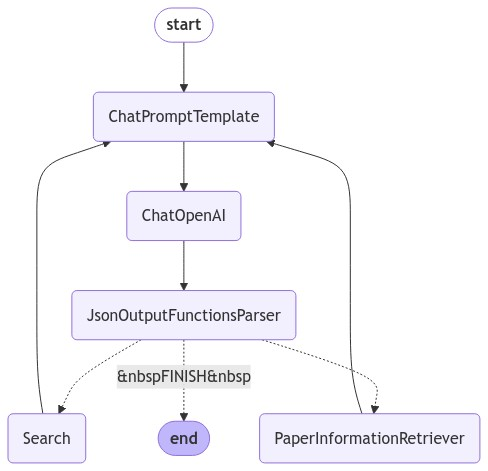

In [37]:
from IPython.display import Image, display
from langgraph.graph.graph import CompiledGraph

def display_mermaid_diagram(chain : CompiledGraph):
    try:
        # Get the Mermaid diagram text
        mermaid_text = chain.get_graph(xray=True).draw_mermaid()
        
        # Display the Mermaid text
        # print("Mermaid Diagram Text:")
        # print("```mermaid")
        # print(mermaid_text)
        # print("```")
        #         # Render and display the image
        print("\nRendered Diagram:")
        display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
    except Exception as e:
        print(f"An error occurred: {e}")

# Usage
display_mermaid_diagram(chain)

##### ❓ Question #2:

How could you make sure your Agent uses specific tools that you wish it to use? Are there any ways to concretely set a flow through tools?

#### 🔍Answer #2:

Given that we're already using a supervisor agent, there are indeed several ways
to ensure specific tool usage and set a concrete flow through tools within this
framework. Here are some strategies:


1. Tool Assignment to Specific Agents:
   When creating worker agents, you can explicitly assign specific tools to each agent. For example:

   ```python
   research_agent = create_agent(llm, [tavily_tool], "You are a web researcher.")
   code_agent = create_agent(llm, [python_repl_tool], "You are a coder.")
   ```

   This ensures that each agent only has access to the tools you want it to use.

2. Supervisor Logic:
   You can modify the supervisor's decision-making logic to route tasks to specific agents based on the required tools. For example:

   ```python
   def supervisor_logic(state):
       if "search" in state["input"].lower():
           return "Researcher"
       elif "code" in state["input"].lower():
           return "Coder"
       else:
           return "FINISH"
   ```

3. Conditional Edges:
   In the graph construction, you can use conditional edges to enforce a specific flow:

   ```python
   workflow.add_conditional_edges(
       "supervisor",
       supervisor_logic,
       {
           "Researcher": "Researcher",
           "Coder": "Coder",
           "FINISH": END
       }
   )
   ```

4. Explicit Instructions in Prompts:
   Include specific instructions about tool usage in the system prompts for each agent:

   ```python
   research_agent = create_agent(
       llm, 
       [tavily_tool], 
       "You are a web researcher. Always use the Tavily search tool for research tasks."
   )
   ```

5. Forced Tool Usage:
   Implement a wrapper around your agents that forces them to use a specific tool before moving to the next step:

   ```python
   def force_tool_usage(agent, tool, input_data):
       tool_result = tool.run(input_data)
       return agent.run(tool_result)
   ```

6. State-based Routing:
   Maintain a state that tracks which tools have been used and use this to determine the next step:

   ```python
   class AgentState(TypedDict):
       messages: Annotated[Sequence[BaseMessage], operator.add]
       next: str
       tools_used: List[str]
   ```

   Then update the supervisor logic to check and update the `tools_used` list.

7. Tool-specific Nodes:
   Instead of giving agents multiple tools, create separate nodes for each tool and connect them in a specific order in your graph.

By combining these strategies, you can create a more deterministic flow through your tools while still maintaining the flexibility of the supervisor-agent structure.

[Source: LangChain documentation on Supervision](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/)

## Document Writing Team - A LangGraph for Writing, Editing, and Planning a LinkedIn post.

Let's run it all back, this time specifically creating tools, agent nodes, and a graph for planning, writing, and editing a LinkedIn post!

### Tool Creation

Let's create some tools that will help us understand, open, work with, and edit documents to our liking!

In [47]:
from tempfile import TemporaryDirectory
tmpdir =TemporaryDirectory()
from pathlib import Path

WORKING_DIRECTORY=Path(tmpdir.name)
print(f"Working directory: {WORKING_DIRECTORY}")


Working directory: /tmp/tmp0sg0dyu0


In [118]:
import os
import uuid
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, List, Optional, Annotated
from langchain.agents.agent import AgentExecutor
from typing_extensions import TypedDict
from langchain.tools import tool
from langchain.tools import Tool

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ] = {},
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines: list[str] = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


##### 🏗️ Activity #3:

Describe, briefly, what each of these tools is doing in your own words.

- `create_outline`
  - This function generates a structured outline document from a list of main points, saving it to a specified file within the working directory.

- `read_document`
  - This function reads a document from the working directory and returns its content. It can optionally return a specific range of lines from the document.

- `write_document`
  - This function writes the provided content to a file in the working directory. If the file already exists, it will be overwritten.

- `edit_document`
  - This function modifies a document in the working directory by inserting new lines at the specified line numbers. Existing content is shifted down to accommodate the new insertions.

### Document Writing State

Just like with our Research Team state - we want to keep track of a few things, however this time - we also want to keep track of which files we've created - so let's add that here!

In [105]:
import operator
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage

class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str

### Document Writing Prelude Function

Since we have a working directory - we want to be clear about what our current working directory looks like - this helper function will allow us to do that cleanly!

In [119]:
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

### Document Writing Node Creation



In [133]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from langchain.agents.agent import AgentExecutor
from typing_extensions import TypedDict
import uuid
import os
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )


doc_writer_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert writing technical LinkedIn posts.\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_agent(
    llm,
    [create_outline, read_document],
    ("You are an expert senior researcher tasked with writing a LinkedIn post outline and"
    " taking notes to craft a LinkedIn post.\n{current_files}"),
)
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

copy_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert copy editor who focuses on fixing grammar, spelling, and tone issues\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_copy_editor_agent = prelude | copy_editor_agent
copy_editing_node = functools.partial(
    agent_node, agent=context_aware_copy_editor_agent, name="CopyEditor"
)

dopeness_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert in dopeness, litness, coolness, etc - you edit the document to make sure it's dope."
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_dopeness_editor_agent = prelude | dopeness_editor_agent
dopeness_node = functools.partial(
    agent_node, agent=context_aware_dopeness_editor_agent, name="DopenessEditor"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers: {team_members}. You should always verify the technical"
    " contents after any edits are made. "
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When each team is finished,"
    " you must respond with FINISH."),
    ["DocWriter", "NoteTaker", "DopenessEditor", "CopyEditor"],
)


### Document Writing Team LangGraph Construction

This part is almost exactly the same (with a few extra nodes) as our Research Team LangGraph construction - so we'll leave it as one block!

In [134]:
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("CopyEditor", copy_editing_node)
authoring_graph.add_node("DopenessEditor", dopeness_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("CopyEditor", "supervisor")
authoring_graph.add_edge("DopenessEditor", "supervisor")

authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "CopyEditor" : "CopyEditor",
        "DopenessEditor" : "DopenessEditor",
        "FINISH": END,
    },
)

authoring_graph.set_entry_point("supervisor")
chain = authoring_graph.compile()


#### Display Graph

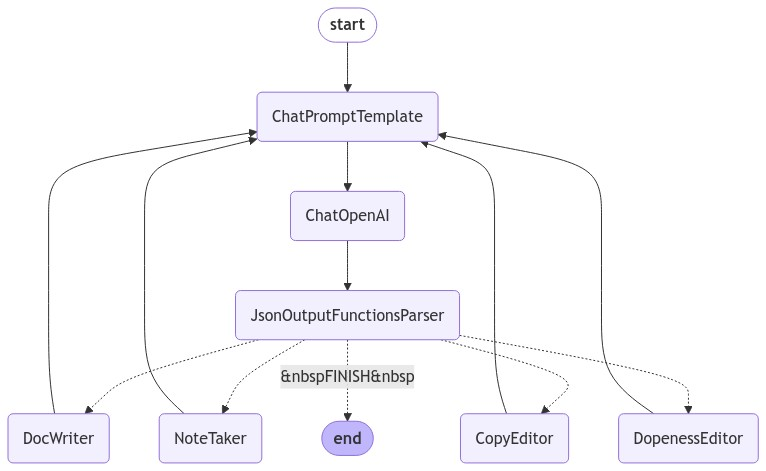

In [135]:
from IPython.display import Image, display

try:
    display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

Just as before - we'll need to create an "interface" between the level above, and our graph.

In [136]:
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

Now we can test this out!

> NOTE: It is possible you may see an error here - rerun the cell to clear.

In [137]:
# for s in authoring_chain.stream(
#     "Write an outline for for a short LinkedIn post on Linear Regression and write it to disk.",
#     {"recursion_limit": 100},
# ):
#     if "__end__" not in s:
#         print(s)
#         print("---")

In [138]:
from langchain_core.messages import HumanMessage
from langgraph.pregel.io import AddableUpdatesDict
import json
for s in authoring_chain.stream(
    "Write an outline for for a short LinkedIn post on Linear Regression and write it to disk.",
    {"recursion_limit": 100},
):
    # print(type(s).__name__)
    # if not isinstance(s, AddableUpdatesDict):
    #    print("not an AddableUpdatesDict. type: ", type(s).__name__)
    #    continue
    # # iterate over keys and pretty print the values
    print(json.dumps(
        s,
        indent=4,
        default=lambda x: x.__dict__,
        ensure_ascii=False
    ))
    print("---")

{
    "supervisor": {
        "next": "DocWriter"
    }
}
---
{
    "DocWriter": {
        "messages": [
            {
                "content": "The outline for a short LinkedIn post on Linear Regression has been successfully written and saved to the file \"LinkedIn_Post_Outline_Linear_Regression.txt\".",
                "additional_kwargs": {},
                "response_metadata": {},
                "type": "human",
                "name": "DocWriter",
                "id": null,
                "example": false
            }
        ]
    }
}
---
{
    "supervisor": {
        "next": "NoteTaker"
    }
}
---
{
    "NoteTaker": {
        "messages": [
            {
                "content": "The outline for the LinkedIn post on Linear Regression has been successfully created and saved to the file \"LinkedIn_Post_Outline_Linear_Regression.txt\". The main points of the post will be:\n\n1. Introduction to Linear Regression\n2. Why Linear Regression is important\n3. How Linear Regressi

## Meta-Supervisor

Finally, now that we have our two LangGraph agents (some of which are already multi-agent), we can build a supervisor that sits above all of them!

The final process, surprisingly, is quite straight forward!

Let's jump in!

First off - we'll need to create our supervisor agent node.

In [139]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI


llm = ChatOpenAI(model="gpt-4")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When all workers are finished,"
    " you must respond with FINISH.",
    ["Research team", "LinkedIn team"],
)

We'll also create our new state - as well as some methods to help us navigate the new state and the subgraphs.

> NOTE: We only pass the most recent message from the parent graph to the subgraph, and we only extract the most recent message from the subgraph to include in the state of the parent graph.

In [140]:
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

def get_last_message(state: State) -> str:
    return state["messages"][-1].content

def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}

Next, we'll create our base graph.

Notice how each node we're adding is *AN ENTIRE LANGGRAPH AGENT* (wrapped into an LCEL chain with our helper functions above).

In [141]:
super_graph = StateGraph(State)

super_graph.add_node("Research team", get_last_message | research_chain | join_graph)
super_graph.add_node(
    "LinkedIn team", get_last_message | authoring_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

Next, we'll create our edges!

This process is completely idenctical to what we've seen before - just addressing the LangGraph subgraph nodes instead of individual nodes.

In [142]:
super_graph.add_edge("Research team", "supervisor")
super_graph.add_edge("LinkedIn team", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "LinkedIn team": "LinkedIn team",
        "Research team": "Research team",
        "FINISH": END,
    },
)
super_graph.set_entry_point("supervisor")
super_graph = super_graph.compile()

That's it!

Now we can finally use our full agent!

In [143]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Write a LinkedIn post on the paper 'Extending Llama-3’s Context Ten-Fold Overnight'. First consult the research team. Then make sure you consult the LinkedIn team, and check for copy editing and dopeness, and write the file to disk."
            )
        ],
    },
    {"recursion_limit": 30},
):
    if "__end__" not in s:
        print(s)
        print("---")
     


{'supervisor': {'next': 'Research team'}}
---


TypeError: string indices must be integers, not 'str'

## SAMPLE POST!

```
A game-changing breakthrough in AI just touched down! The Llama-3-8B-Instruct model just went from cool to ultra-cool, extending its context length from 8K to a mind-blowing 80K. And guess what? It kept all its original capabilities for shorter contexts.

Talk about speed? This upgrade was pulled off in only 8 hours using an 8xA800 (80G) GPU machine. Big ups to the 3.5K synthetic training samples generated by GPT-4 that made this possible. This shows how large language models are pushing boundaries and taking giant leaps in the game.

Here's the dopest part: the squad is going all out, releasing all related resources including data, model, and training code, for everyone. This is how we move the needle, with open collaboration.

For more deets on this cutting-edge breakthrough and further upgrades, hit up our dedicated teams. We've got the info, you bring the curiosity.

#AI #MachineLearning #OpenSource #Innovation #Collaboration #Advancement
```